Validation Metrics: {'RMSE': 806.5985916793102, 'R²': 0.859112389995301}
Test Metrics: {'RMSE': 655.531962132451, 'R²': 0.8637605968289401}


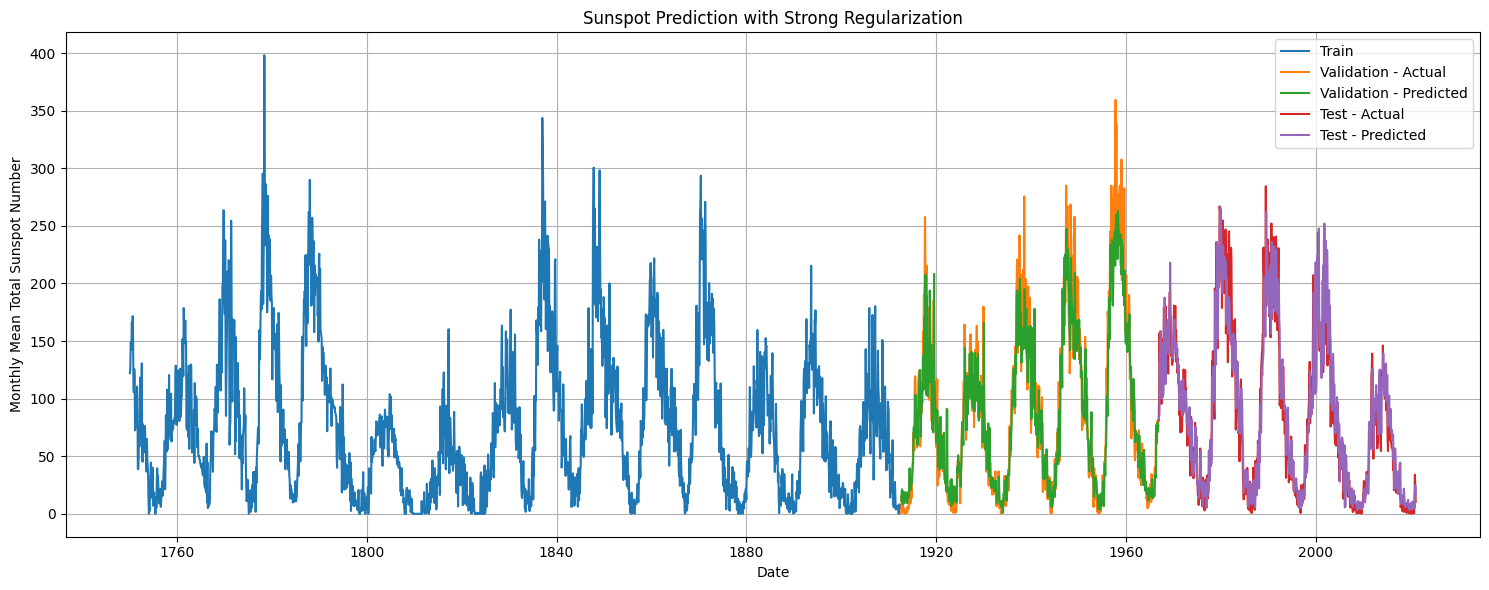

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# 1. Veri yükleme
df = pd.read_csv("Sunspots.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values("Date").reset_index(drop=True)

# 2. Sade ve anlamlı feature engineering
df['sunspot_lag1'] = df['Monthly Mean Total Sunspot Number'].shift(1)
df['sunspot_lag12'] = df['Monthly Mean Total Sunspot Number'].shift(12)
df['cycle_sin'] = np.sin(2 * np.pi * df.index / 132)
df['cycle_cos'] = np.cos(2 * np.pi * df.index / 132)

df = df.dropna().reset_index(drop=True)

features = ['sunspot_lag1', 'sunspot_lag12', 'cycle_sin', 'cycle_cos']
X = df[features]
y = df['Monthly Mean Total Sunspot Number']
dates = df['Date']

# 3. Zaman serisi bölme: %60 train, %20 val, %20 test
n = len(df)
train_end = int(n * 0.6)
val_end = int(n * 0.8)

X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
X_val, y_val = X.iloc[train_end:val_end], y.iloc[train_end:val_end]
X_test, y_test = X.iloc[val_end:], y.iloc[val_end:]

dates_train = dates.iloc[:train_end]
dates_val = dates.iloc[train_end:val_end]
dates_test = dates.iloc[val_end:]

# 4. LightGBM veri setleri
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val)

# 5. Parametreler: sert regularizasyon ve rastgelelik
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.01,
    'max_depth': 4,
    'num_leaves': 20,
    'subsample': 0.6,
    'colsample_bytree': 0.6,
    'bagging_freq': 5,
    'bagging_fraction': 0.6,
    'reg_alpha': 5.0,
    'reg_lambda': 5.0,
    'verbose': -1,
    'seed': 42
}

# 6. Model eğitimi
model = lgb.train(
    params,
    train_data,
    num_boost_round=2000,
    valid_sets=[val_data],

)

# 7. Tahminler
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)
y_pred_test = model.predict(X_test, num_iteration=model.best_iteration)

# 8. Değerlendirme fonksiyonu
def evaluate(y_true, y_pred):
    return {
        'RMSE': mean_squared_error(y_true, y_pred),
        'R²': r2_score(y_true, y_pred)
    }

print("Validation Metrics:", evaluate(y_val, y_pred_val))
print("Test Metrics:", evaluate(y_test, y_pred_test))

# 9. Sonuçları çizdirme
plt.figure(figsize=(15,6))
plt.plot(dates_train, y_train, label='Train')
plt.plot(dates_val, y_val, label='Validation - Actual')
plt.plot(dates_val, y_pred_val, label='Validation - Predicted')
plt.plot(dates_test, y_test, label='Test - Actual')
plt.plot(dates_test, y_pred_test, label='Test - Predicted')
plt.title("Sunspot Prediction with Strong Regularization")
plt.xlabel("Date")
plt.ylabel("Monthly Mean Total Sunspot Number")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


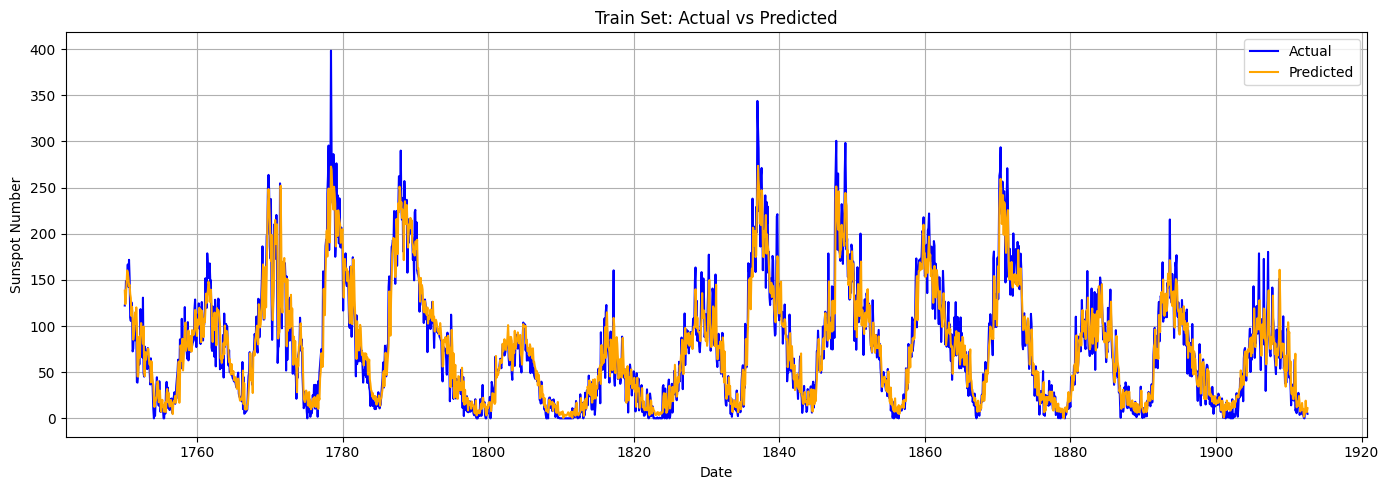

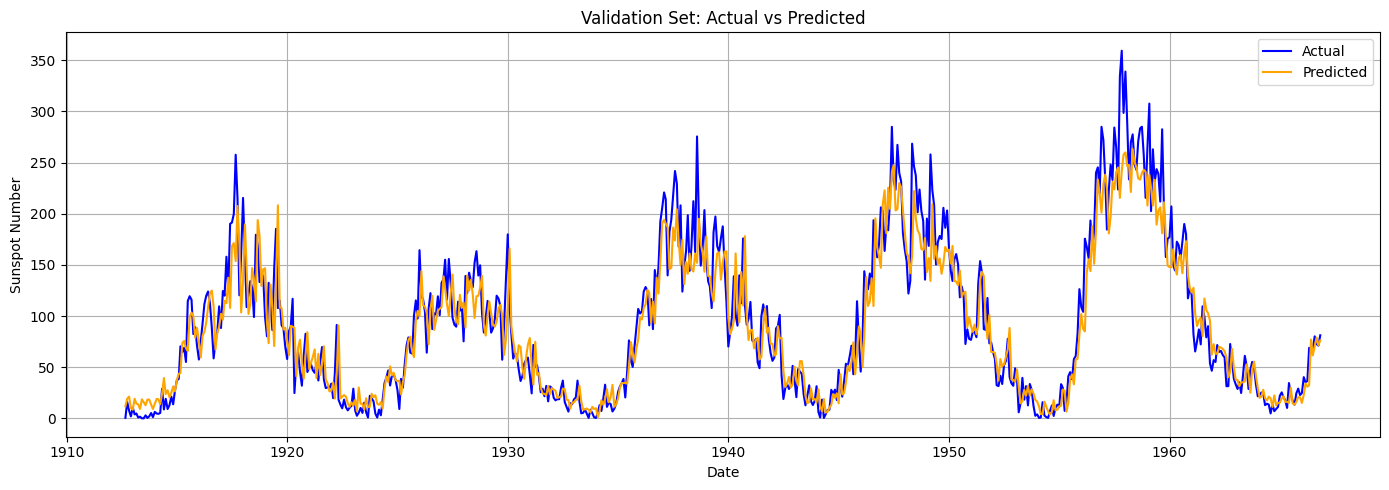

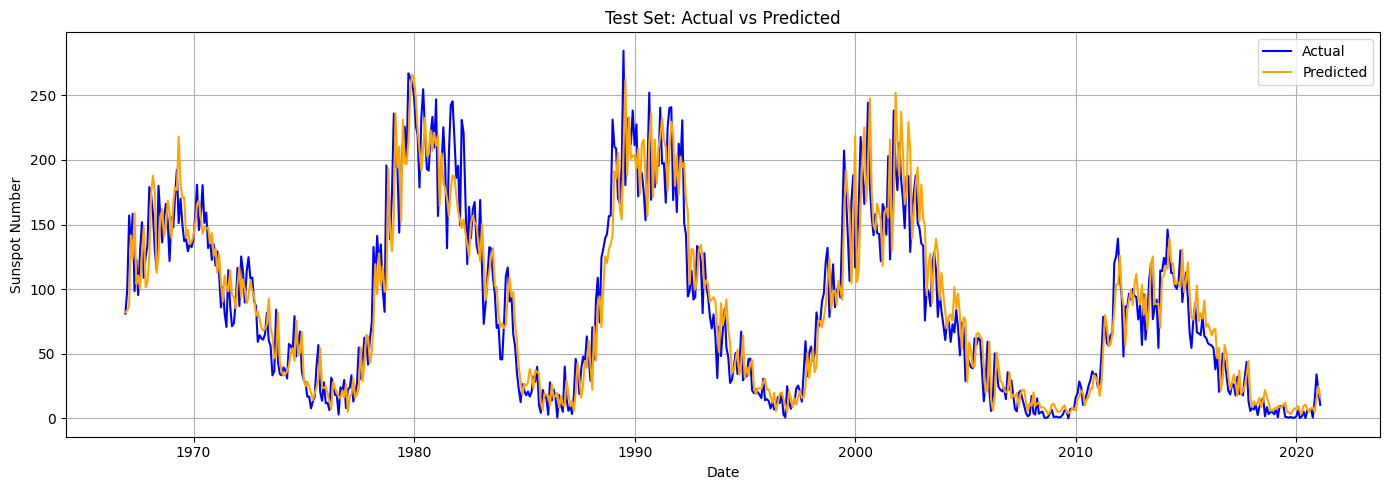

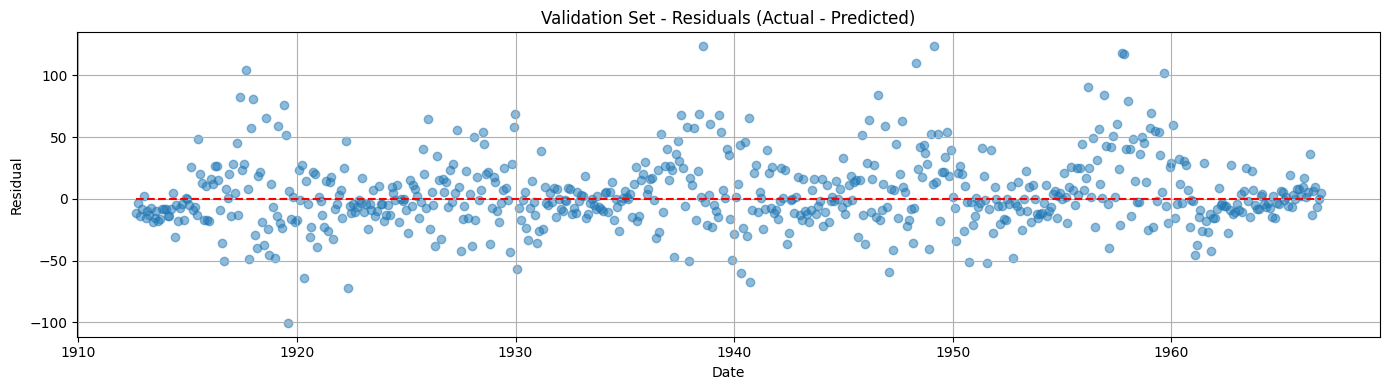

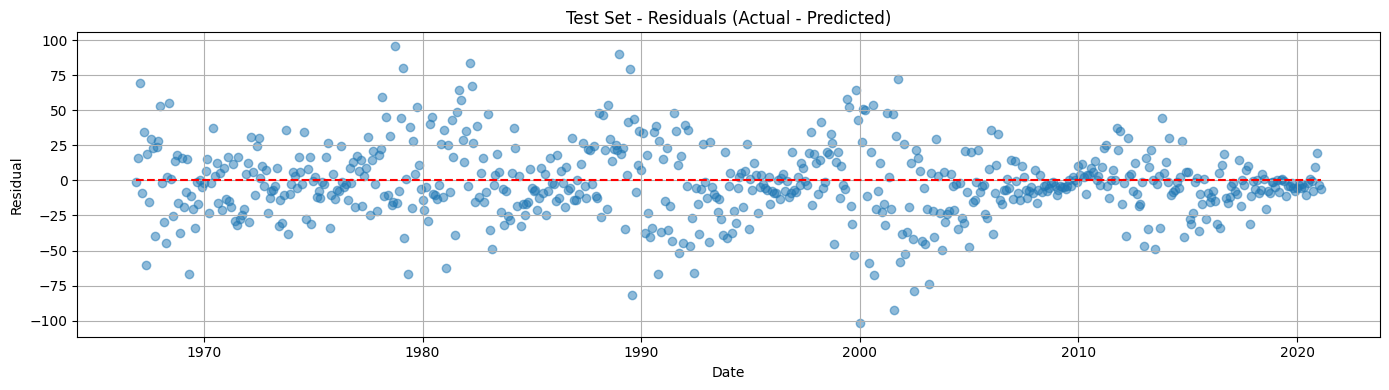

C:\Users\Monster\AppData\Local\Temp\ipykernel_17336\1315571510.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='importance', y='feature', palette='viridis')


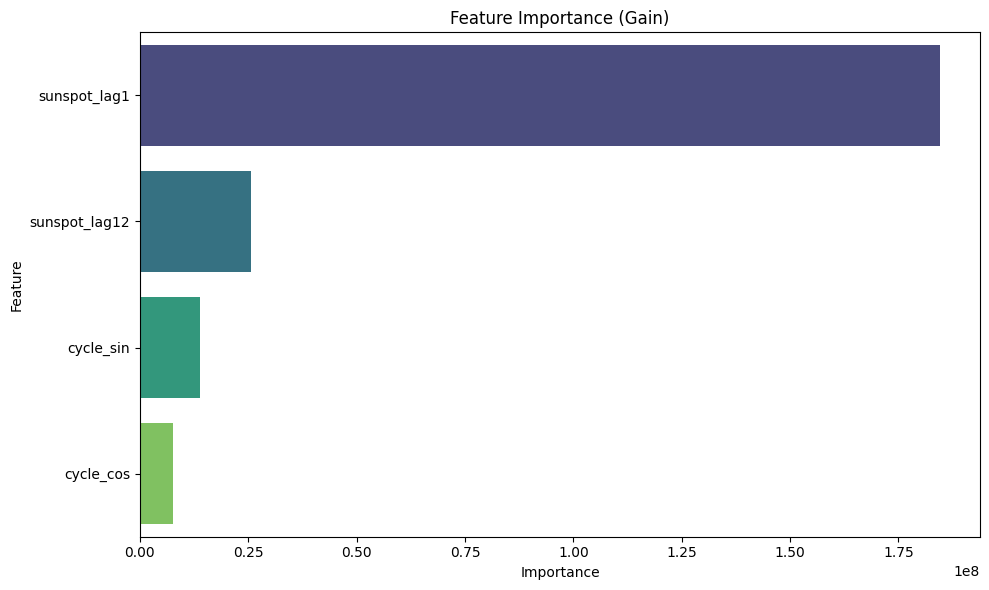

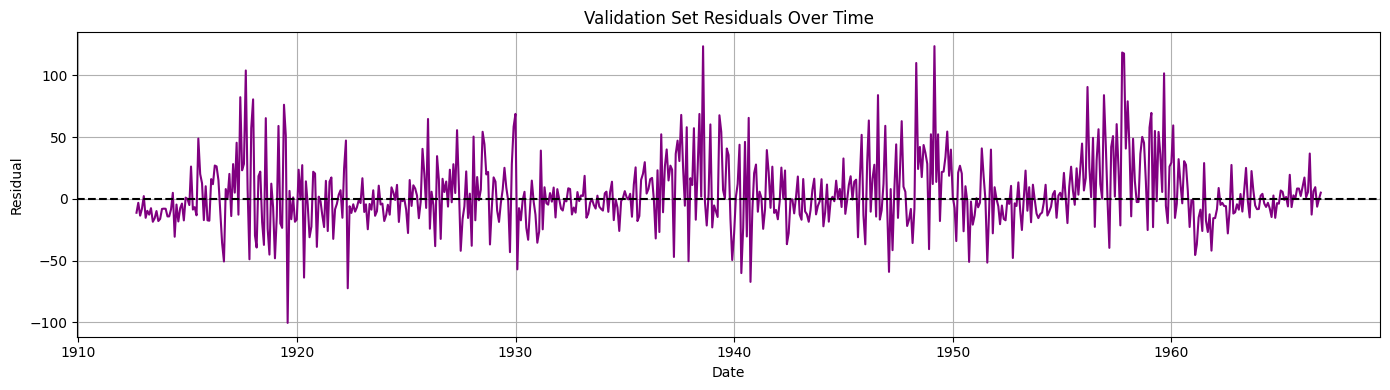

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Gerçek vs Tahmin grafikleri ayrı ayrı çizdirme fonksiyonu
def plot_actual_vs_pred(dates, actual, predicted, title):
    plt.figure(figsize=(14, 5))
    plt.plot(dates, actual, label='Actual', color='blue')
    plt.plot(dates, predicted, label='Predicted', color='orange')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Sunspot Number')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 2. Hata dağılımı (residuals)
def plot_residuals(dates, actual, predicted, title):
    residuals = actual - predicted
    plt.figure(figsize=(14, 4))
    plt.scatter(dates, residuals, alpha=0.5)
    plt.hlines(0, dates.min(), dates.max(), colors='r', linestyles='dashed')
    plt.title(title + " - Residuals (Actual - Predicted)")
    plt.xlabel('Date')
    plt.ylabel('Residual')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 3. Feature Importance grafiği
def plot_feature_importance(model, feature_names):
    importance = model.feature_importance(importance_type='gain')
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values(by='importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df, x='importance', y='feature', palette='viridis')
    plt.title("Feature Importance (Gain)")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

# --- Kullanım ---

# Gerçek vs Tahmin
plot_actual_vs_pred(dates_train, y_train, model.predict(X_train, num_iteration=model.best_iteration), "Train Set: Actual vs Predicted")
plot_actual_vs_pred(dates_val, y_val, y_pred_val, "Validation Set: Actual vs Predicted")
plot_actual_vs_pred(dates_test, y_test, y_pred_test, "Test Set: Actual vs Predicted")

# Hata dağılımı (Residual plot)
plot_residuals(dates_val, y_val, y_pred_val, "Validation Set")
plot_residuals(dates_test, y_test, y_pred_test, "Test Set")

# Feature Importance
plot_feature_importance(model, features)

# Tahmin hatalarının zaman içindeki değişimi (validation)
plt.figure(figsize=(14, 4))
residuals_val = y_val - y_pred_val
plt.plot(dates_val, residuals_val, label='Residuals (Validation)', color='purple')
plt.axhline(0, color='black', linestyle='dashed')
plt.title("Validation Set Residuals Over Time")
plt.xlabel("Date")
plt.ylabel("Residual")
plt.grid(True)
plt.tight_layout()
plt.show()


In [3]:
# 1. İlk model: Train -> Validation
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.01,
    'max_depth': 4,
    'num_leaves': 20,
    'subsample': 0.6,
    'colsample_bytree': 0.6,
    'bagging_freq': 5,
    'bagging_fraction': 0.6,
    'reg_alpha': 5.0,
    'reg_lambda': 5.0,
    'verbose': -1,
    'seed': 42
}

model_1 = lgb.train(
    params,
    train_data,
    num_boost_round=2000,
    valid_sets=[val_data],

)

y_pred_val = model_1.predict(X_val, num_iteration=model_1.best_iteration)

# 2. İkinci model: Train + Validation -> Test
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])
train_val_data = lgb.Dataset(X_train_val, label=y_train_val)

model_2 = lgb.train(
    params,
    train_val_data,
    
    
)

y_pred_test = model_2.predict(X_test, num_iteration=model_1.best_iteration)

# 3. Değerlendirme
def evaluate(y_true, y_pred):
    return {
        'RMSE': mean_squared_error(y_true, y_pred),
        'R²': r2_score(y_true, y_pred)
    }

print("Validation Metrics:", evaluate(y_val, y_pred_val))
print("Test Metrics:", evaluate(y_test, y_pred_test))

# 4. Grafikler (isteğe bağlı, önceki mesajdaki fonksiyonlar kullanılabilir)


Validation Metrics: {'RMSE': 806.5985916793102, 'R²': 0.859112389995301}
Test Metrics: {'RMSE': 1384.8281658000649, 'R²': 0.7121907493429682}


Validation Metrics: {'RMSE': 804.3880862467777, 'R²': 0.8708953699263348}
Test Metrics: {'RMSE': 1343.976180641608, 'R²': 0.7246182212465506}


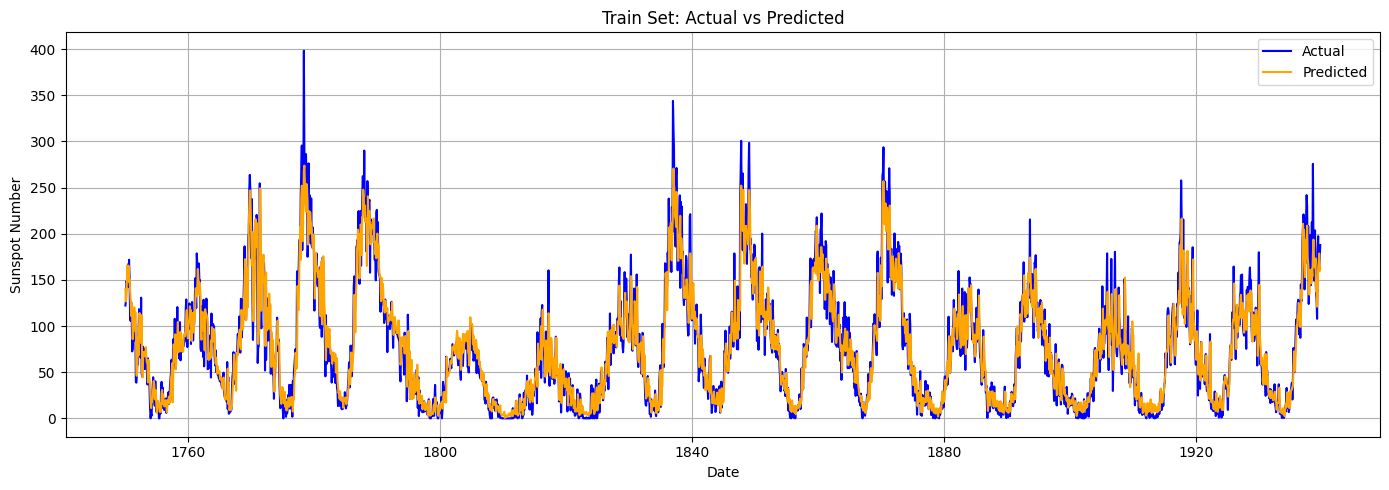

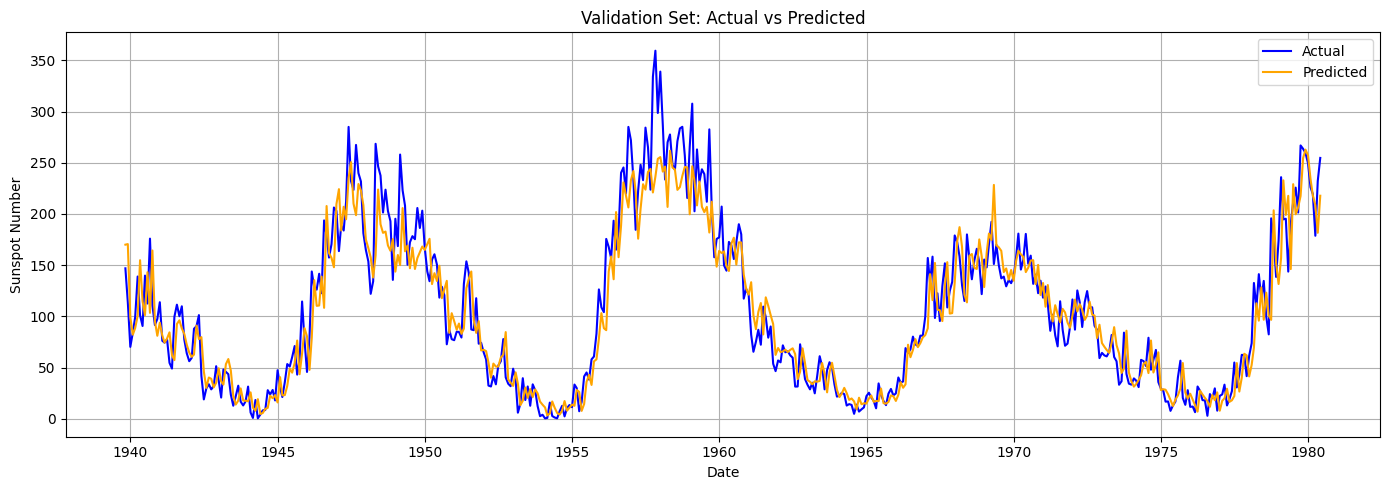

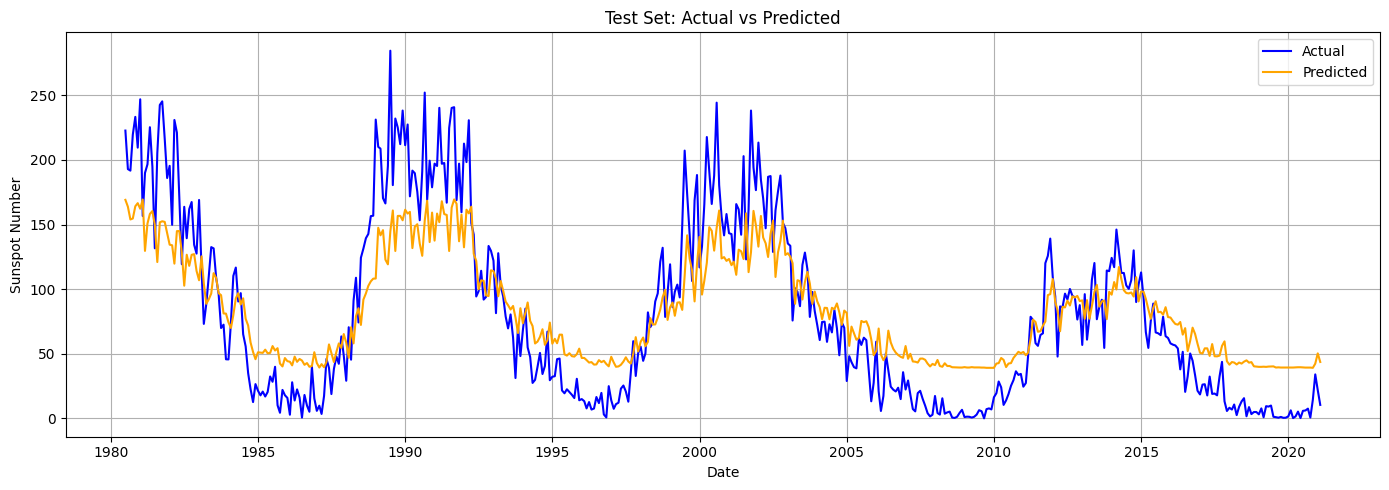

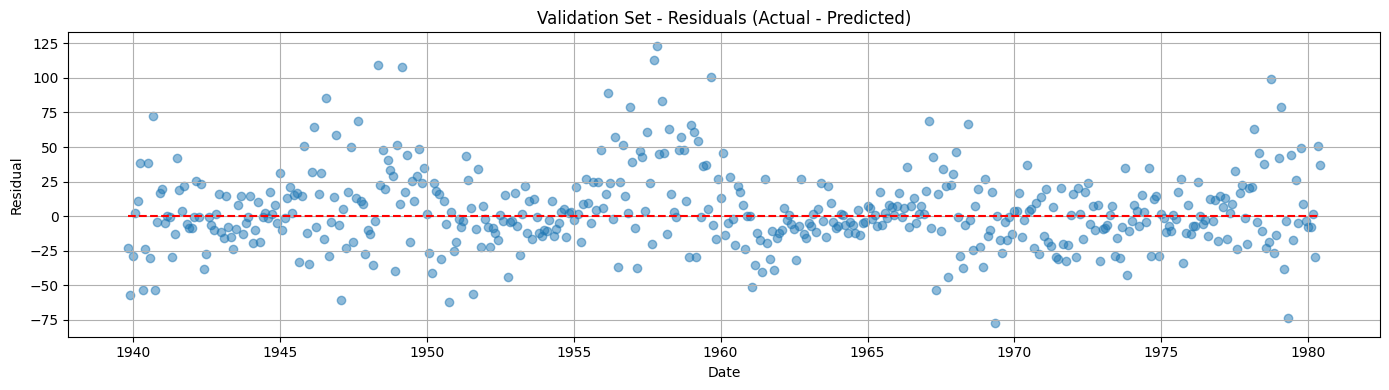

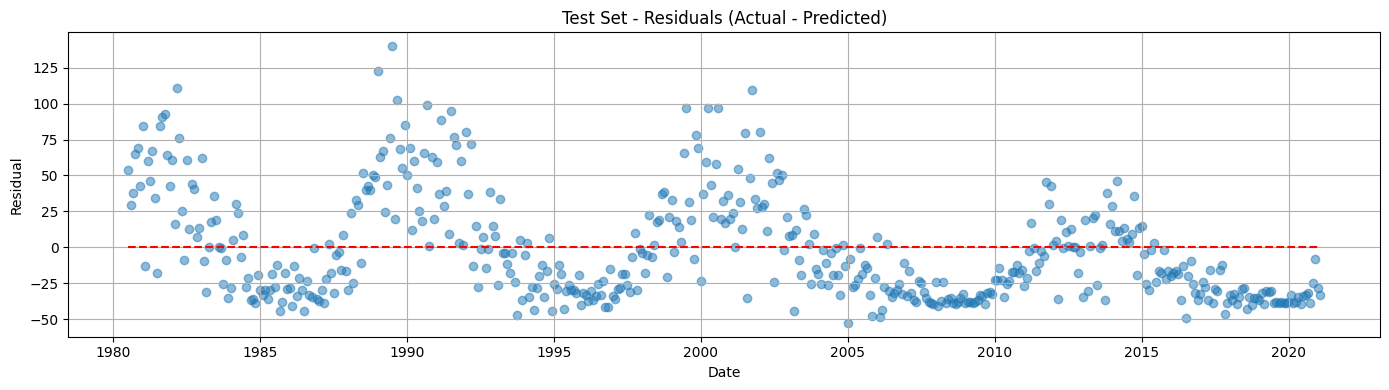

C:\Users\Monster\AppData\Local\Temp\ipykernel_17336\3850712949.py:117: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='importance', y='feature', palette='viridis')


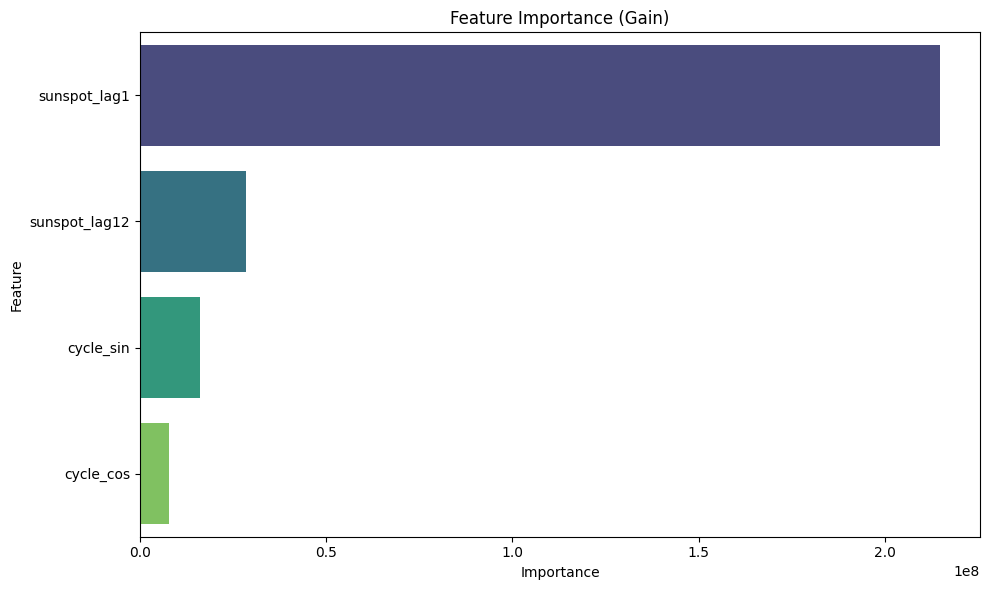

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns

# 1. Veri yükleme
df = pd.read_csv("Sunspots.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values("Date").reset_index(drop=True)

# 2. Feature engineering (sade)
df['sunspot_lag1'] = df['Monthly Mean Total Sunspot Number'].shift(1)
df['sunspot_lag12'] = df['Monthly Mean Total Sunspot Number'].shift(12)
df['cycle_sin'] = np.sin(2 * np.pi * df.index / 132)
df['cycle_cos'] = np.cos(2 * np.pi * df.index / 132)
df = df.dropna().reset_index(drop=True)

features = ['sunspot_lag1', 'sunspot_lag12', 'cycle_sin', 'cycle_cos']
X = df[features]
y = df['Monthly Mean Total Sunspot Number']
dates = df['Date']

# 3. Zaman serisi bölme: %60 train, %20 val, %20 test
n = len(df)
train_end = int(n * 0.7)
val_end = int(n * 0.85)

X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
X_val, y_val = X.iloc[train_end:val_end], y.iloc[train_end:val_end]
X_test, y_test = X.iloc[val_end:], y.iloc[val_end:]

dates_train = dates.iloc[:train_end]
dates_val = dates.iloc[train_end:val_end]
dates_test = dates.iloc[val_end:]


# 4. Model parametreleri
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.01,
    'max_depth': 4,
    'num_leaves': 20,
    'subsample': 0.6,
    'colsample_bytree': 0.6,
    'bagging_freq': 5,
    'bagging_fraction': 0.6,
    'reg_alpha': 5.0,
    'reg_lambda': 5.0,
    'verbose': -1,
    'seed': 42
}

# 5. İlk model: Train -> Validation
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val)

model_1 = lgb.train(
    params,
    train_data,
    num_boost_round=2000,
    valid_sets=[val_data],

)

y_pred_val = model_1.predict(X_val, num_iteration=model_1.best_iteration)

# 6. İkinci model: Train + Validation -> Test
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])
train_val_data = lgb.Dataset(X_train_val, label=y_train_val)

model_2 = lgb.train(
    params,
    train_val_data,

)

y_pred_test = model_2.predict(X_test, num_iteration=model_1.best_iteration)

# 7. Değerlendirme fonksiyonu
def evaluate(y_true, y_pred):
    return {
        'RMSE': mean_squared_error(y_true, y_pred),
        'R²': r2_score(y_true, y_pred)
    }

print("Validation Metrics:", evaluate(y_val, y_pred_val))
print("Test Metrics:", evaluate(y_test, y_pred_test))

# 8. Grafik fonksiyonları



def plot_residuals(dates, actual, predicted, title):
    residuals = actual - predicted
    plt.figure(figsize=(14, 4))
    plt.scatter(dates, residuals, alpha=0.5)
    plt.hlines(0, dates.min(), dates.max(), colors='r', linestyles='dashed')
    plt.title(title + " - Residuals (Actual - Predicted)")
    plt.xlabel('Date')
    plt.ylabel('Residual')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_feature_importance(model, feature_names):
    importance = model.feature_importance(importance_type='gain')
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values(by='importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df, x='importance', y='feature', palette='viridis')
    plt.title("Feature Importance (Gain)")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

# 9. Grafiklerin çizilmesi

# Train set tahmini (model_1 ile, en iyi iterasyon)
y_pred_train = model_1.predict(X_train, num_iteration=model_1.best_iteration)

plot_actual_vs_pred(dates_train, y_train, y_pred_train, "Train Set: Actual vs Predicted")
plot_actual_vs_pred(dates_val, y_val, y_pred_val, "Validation Set: Actual vs Predicted")
plot_actual_vs_pred(dates_test, y_test, y_pred_test, "Test Set: Actual vs Predicted")

plot_residuals(dates_val, y_val, y_pred_val, "Validation Set")
plot_residuals(dates_test, y_test, y_pred_test, "Test Set")

plot_feature_importance(model_1, features)


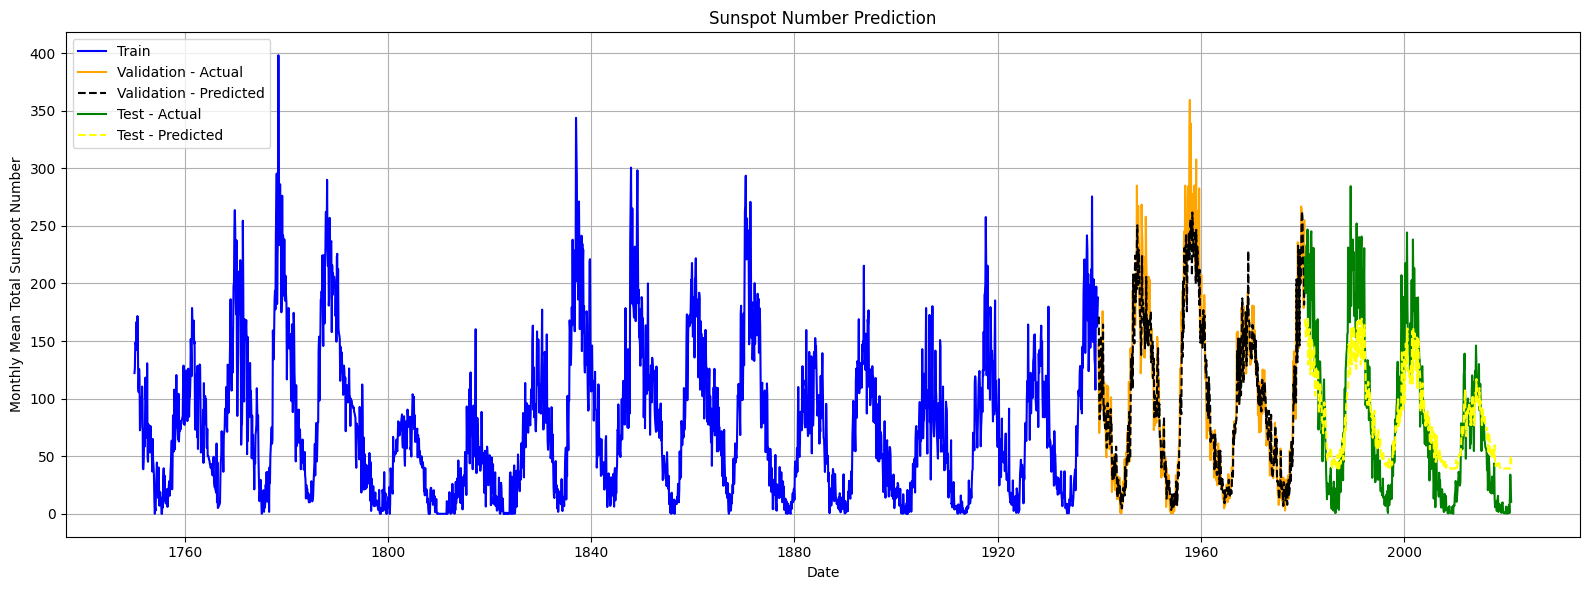

In [5]:
plt.figure(figsize=(16, 6))

plt.plot(dates_train, y_train, label='Train', color='blue')
plt.plot(dates_val, y_val, label='Validation - Actual', color='orange')
plt.plot(dates_val, y_pred_val, label='Validation - Predicted', color='black', linestyle='dashed')
plt.plot(dates_test, y_test, label='Test - Actual', color='green')
plt.plot(dates_test, y_pred_test, label='Test - Predicted', color='yellow', linestyle='dashed')

plt.title("Sunspot Number Prediction")
plt.xlabel("Date")
plt.ylabel("Monthly Mean Total Sunspot Number")
plt.legend(loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()


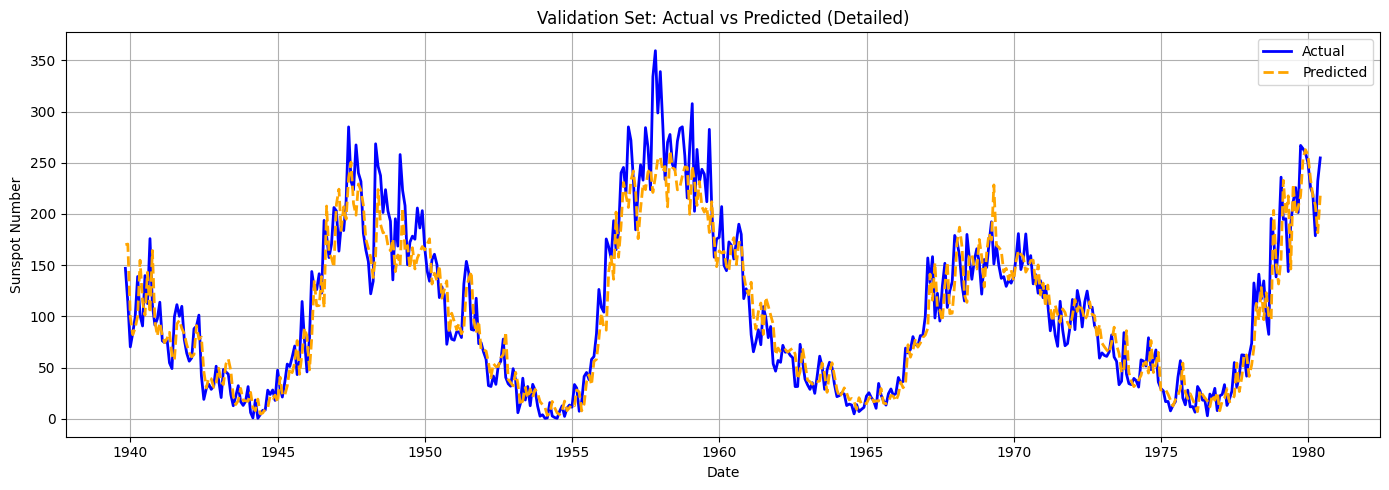

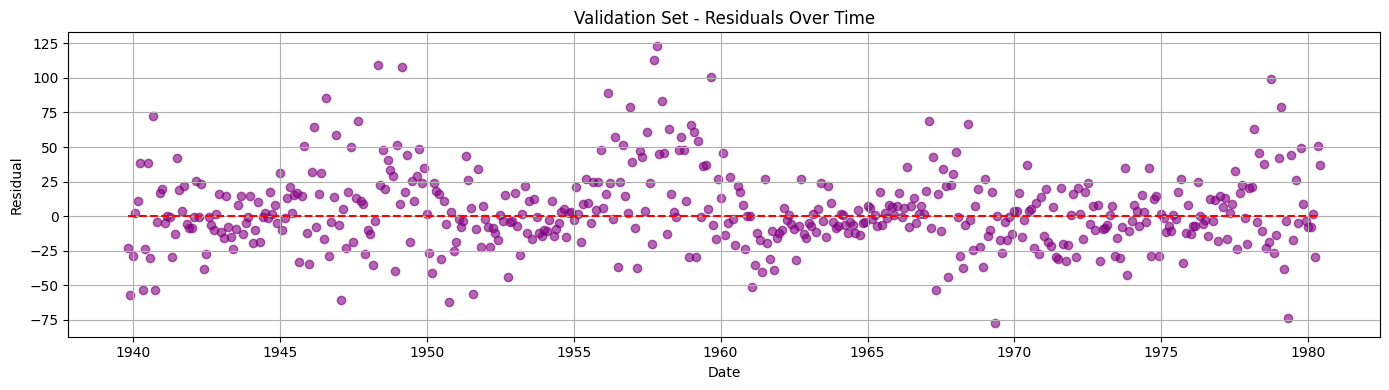

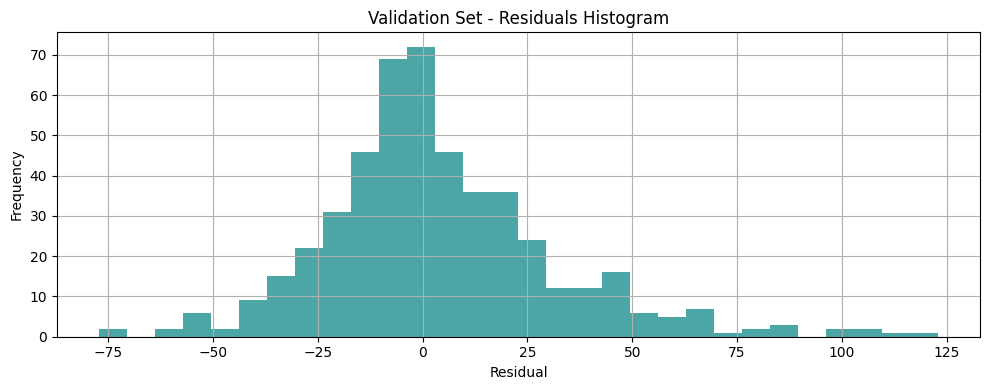

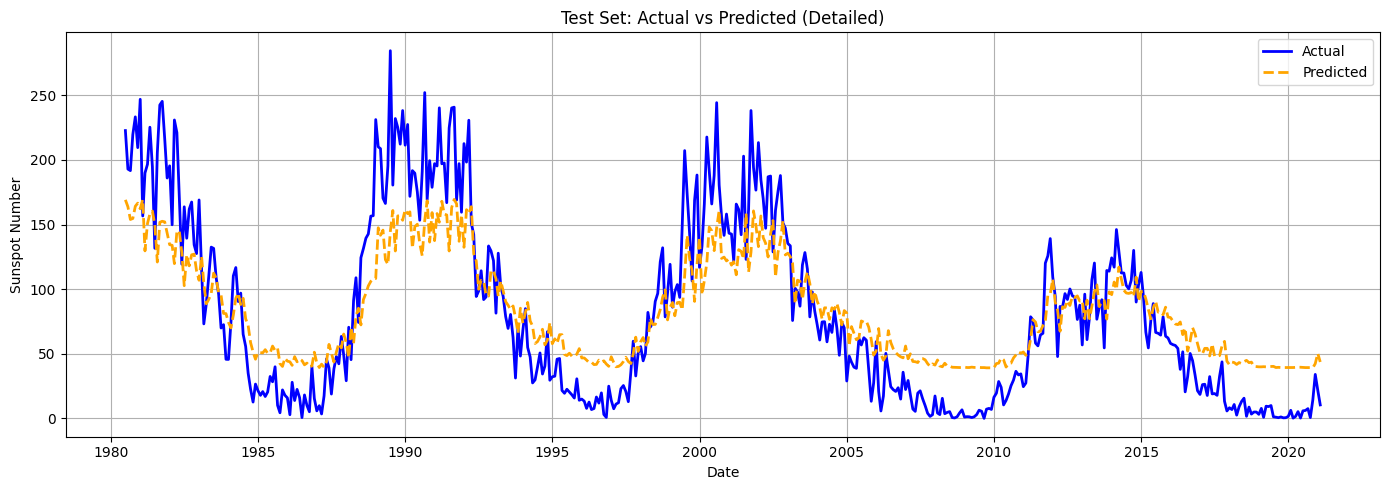

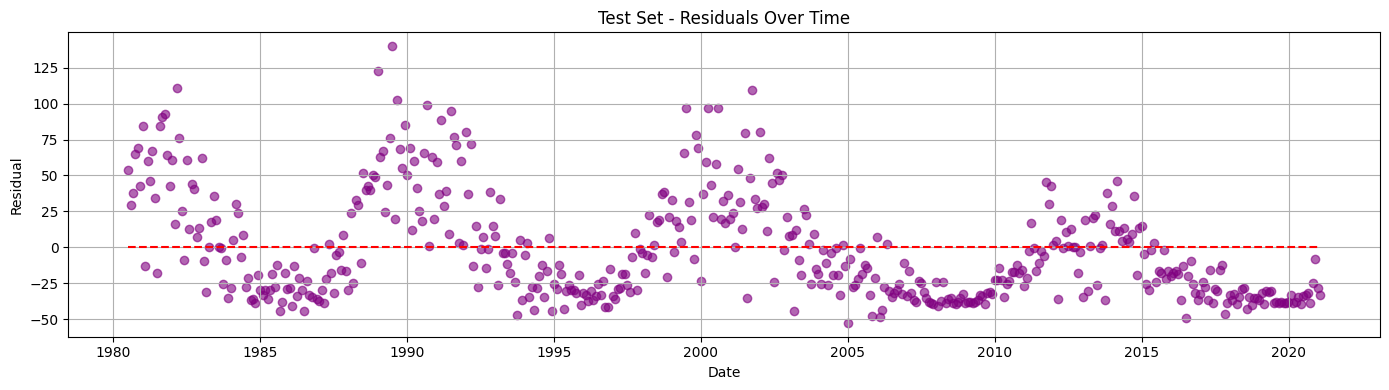

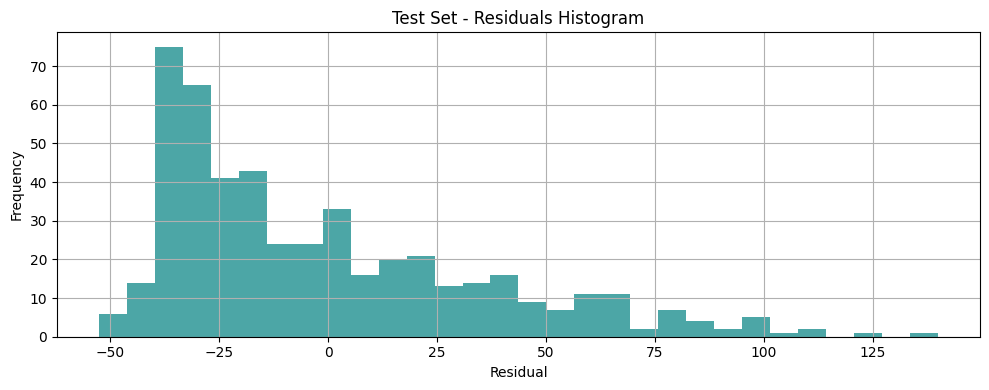

In [ ]:
import matplotlib.dates as mdates

def detailed_actual_vs_pred(dates, actual, predicted, title):
    plt.figure(figsize=(14, 5))
    plt.plot(dates, actual, label='Actual', color='blue', linewidth=2)
    plt.plot(dates, predicted, label='Predicted', color='orange', linestyle='dashed', linewidth=2)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Sunspot Number')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def residual_scatter(dates, actual, predicted, title):
    residuals = actual - predicted
    plt.figure(figsize=(14, 4))
    plt.scatter(dates, residuals, alpha=0.6, color='purple')
    plt.hlines(0, dates.min(), dates.max(), colors='red', linestyles='dashed')
    plt.title(f"{title} - Residuals Over Time")
    plt.xlabel('Date')
    plt.ylabel('Residual')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def residual_histogram(actual, predicted, title):
    residuals = actual - predicted
    plt.figure(figsize=(10, 4))
    plt.hist(residuals, bins=30, color='teal', alpha=0.7)
    plt.title(f"{title} - Residuals Histogram")
    plt.xlabel('Residual')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Kullanımı:

# Validation set detayları
detailed_actual_vs_pred(dates_val, y_val, y_pred_val, "Validation Set: Actual vs Predicted (Detailed)")
residual_scatter(dates_val, y_val, y_pred_val, "Validation Set")
residual_histogram(y_val, y_pred_val, "Validation Set")

# Test set detayları
detailed_actual_vs_pred(dates_test, y_test, y_pred_test, "Test Set: Actual vs Predicted (Detailed)")
residual_scatter(dates_test, y_test, y_pred_test, "Test Set")
residual_histogram(y_test, y_pred_test, "Test Set")




In [8]:
predicted



NameError: name 'predicted' is not defined